# CMRM Assignment No. 2

In [8]:
import os
import numpy as np
import soundfile as sf
import librosa
import sklearn # pip install sklearn
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm # pip install tqdm
from nmf import nmf

## Question 1

In [9]:
## Define directories and lists based on provided code structure
output_dir = "audio/results"
source_dir = "audio/audio/sources"
target_dir = "audio/audio/targets"
sources = ["Bees_Buzzing.mp3", "Wind_Blowing.mp3", "Chainsaw_Sawing.mp3"]
targets = ["Jingle_Bells_Boogie.wav", "Have_Yourself.wav", "Blue_Christmas.wav", "White_Christmas.wav"]

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)


# Define the source and target variables using the respective lists
source = sources[0]  # Selecting "Bees Buzzing.wav" from the sources list
target = targets[0]  # Selecting "Jingle Bells Boogie.wav" from the targets list


In [10]:
## Load signals
Fs = 22050

# Load the source and target waveforms
source_path = os.path.join(source_dir, source)
target_path = os.path.join(target_dir, target)

# Load audio files
source_waveform, _ = librosa.load(source_path, sr=Fs)
target_waveform, _ = librosa.load(target_path, sr=Fs)



Dimension of Ytarget:(2049, 1113)


(0.046439909297052155, 5.38330078125)

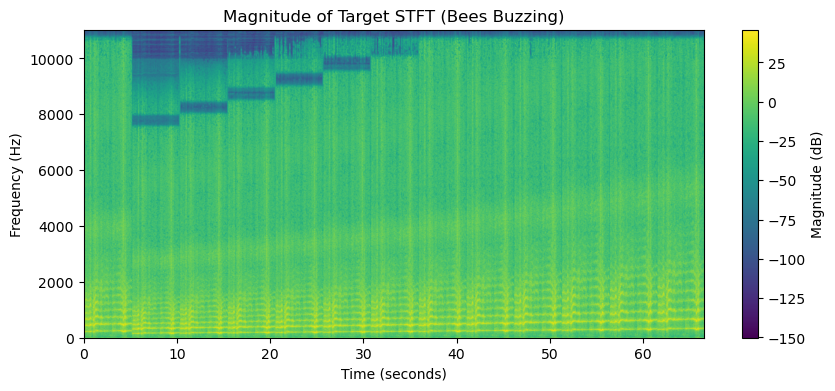

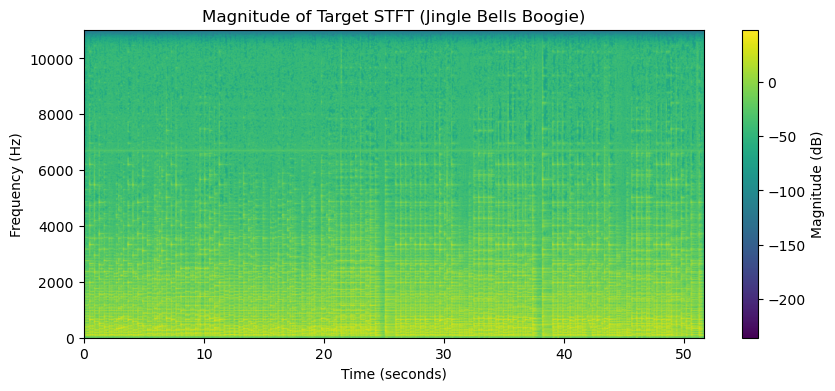

In [11]:
## Define sampling frequency and STFT parameters
N_length = 4096
H_size = 1024

## Compute the STFT of the source waveform
X_source = librosa.stft(source_waveform, n_fft=N_length, hop_length=H_size)

# Extract the magnitude of the source STFT
Y_source = np.abs(X_source)

eps= np.finfo(float).eps
Y_source_db = 20*np.log10(Y_source + eps)
#Y_source_db = np.log10(1 + 10* Y_source)

time_axis= np.arange(X_source.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_source.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]+y_ext]
    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Bees Buzzing)")
plt.imshow(Y_source_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')




# Compute the STFT of the target waveform
X_target = librosa.stft(target_waveform, n_fft=N_length, hop_length=H_size)
# Extract the magnitude of the target STFT

Y_target = np.abs(X_target)
Y_target_db = 20 * np.log10(Y_target + eps)

time_axis= np.arange(X_target.shape[1])/(Fs/H_size)
frequency_axis = np.arange(X_target.shape[0]) / (N_length / Fs)
    
x_ext = (time_axis[1] - time_axis[0]) / 2
y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]+y_ext]
    
# Plot the magnitude of the target STFT    
plt.figure(figsize=(10,4))
plt.title("Magnitude of Target STFT (Jingle Bells Boogie)")
plt.imshow(Y_target_db, extent=image_extent, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

print(f"Dimension of Ytarget:{Y_target.shape}")

# Compute time resolution and frequency resolution
time_res = H_size / Fs  # Time resolution in seconds
freq_res = Fs / N_length  # Frequency resolution in Hz


time_res, freq_res

## Source


## Plot

## Target

## Plot


## Question 2

In [32]:
from nmf import nmf  # NMF function from the nmf.py file

# 1. Initialization of the activation matrix H0 with random values
np.random.seed(42)  # For reproducibility
H0 = np.random.rand(X_source.shape[1], X_target.shape[1])  # Temporal dimensions of X_source and X_target
print(f"Dimension of H0: {H0.shape}")

# 2. Initialization of the normalized template matrix W0
W0 = Y_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Hadamard (element-wise) division
print(f"Dimension of W0: {W0.shape}")

# 3. Definition of Xs (normalization of the source STFT)
Xs = X_source / (np.sum(Y_source, axis=0, keepdims=True) + eps)  # Hadamard division
print(f"Dimension of Xs: {Xs.shape}")

# 4. Execution of NMF using the provided function
W, H = nmf(
    V=Y_target,
    init_W=W0,
    init_H=H0,
    num_iter=50,
    fix_W=True,
    cont_polyphony=10,
    cont_length=7,
    cont_grid=5,
    cont_sparsen=(1, 7)
)

# 5. Calculation of the approximation and error
V_approx = np.dot(W, H)
print(f"Dimension of V: {V_approx.shape}")
error = np.linalg.norm(Y_target - V_approx, ord=2)
print(f"2-Norm of the error between Y_target and V_approx: {error:.4f}")

norm_Y_target = np.linalg.norm(Y_target, ord=2)
print(f"2-Norm of Y_target: {norm_Y_target:.4f}")

normalized_error = error / norm_Y_target
print(f"Normalized error: {normalized_error:.4%}")



## Initialize activations randomly


## Initialize templates according to source frames


Dimension of H0: (1433, 1113)
Dimension of W0: (2049, 1433)
Dimension of Xs: (2049, 1433)


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Dimension of V: (2049, 1113)
2-Norm of the error between Y_target and V_approx: 3183.0830
2-Norm of Y_target: 4717.7866
Normalized error: 67.4698%


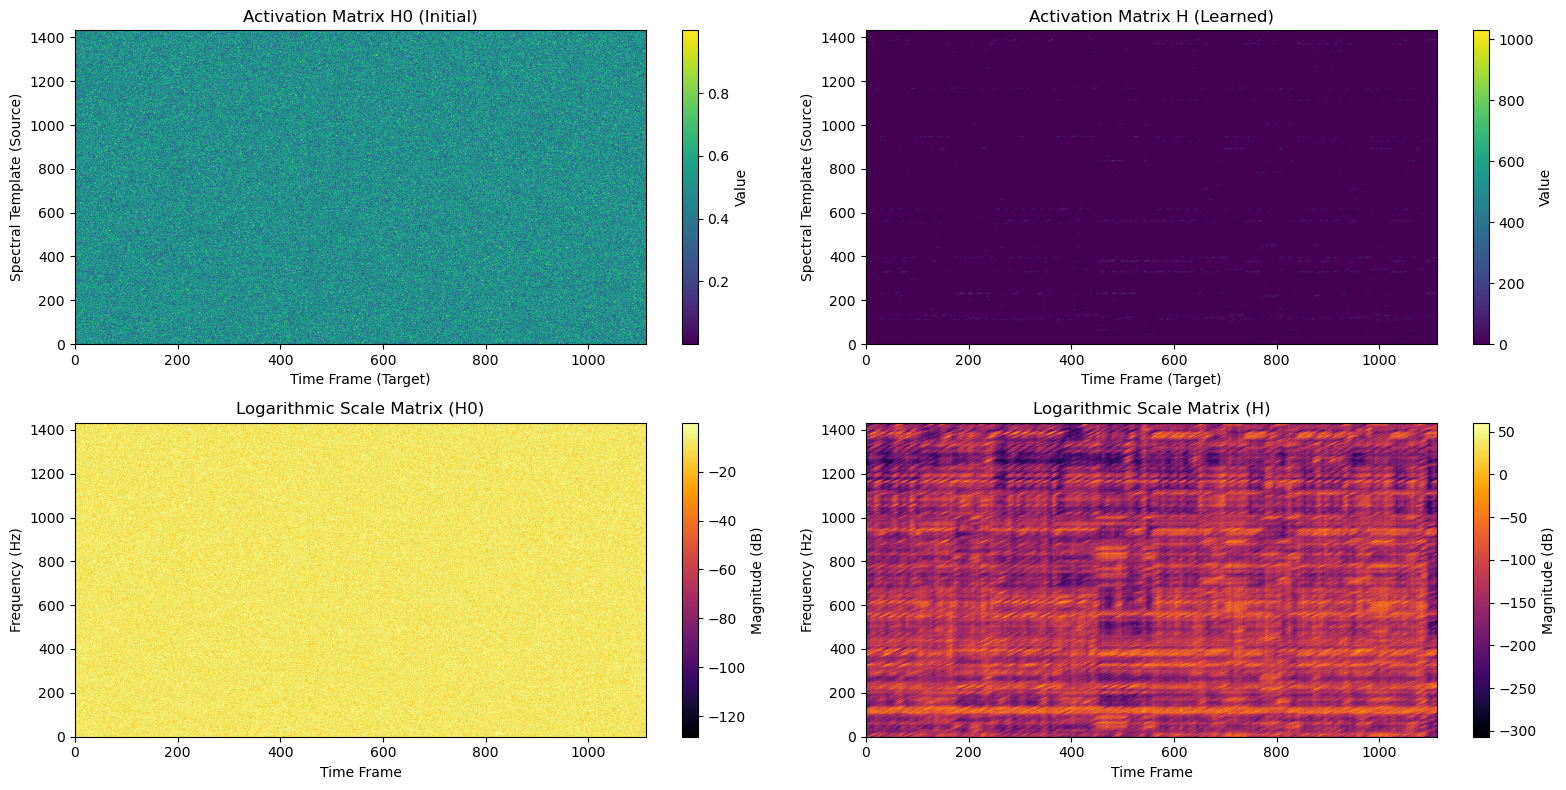

In [33]:
# Plot H0 and H
# 6. Plot the activation matrices (H0 and H)
plt.figure(figsize=(16, 8))

# Initial activation matrix H0
plt.subplot(2, 2, 1)
plt.title("Activation Matrix H0 (Initial)")
plt.imshow(H0, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Value")
plt.xlabel("Time Frame (Target)")
plt.ylabel("Spectral Template (Source)")

# Learned activation matrix H
plt.subplot(2, 2, 2)
plt.title("Activation Matrix H (Learned)")
plt.imshow(H, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label="Value")
plt.xlabel("Time Frame (Target)")
plt.ylabel("Spectral Template (Source)")

# Logarithmic scale matrix (H0)
plt.subplot(2, 2, 3)
plt.title("Logarithmic Scale Matrix (H0)")
plt.imshow(20 * np.log10(H0 + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time Frame")
plt.ylabel("Frequency (Hz)")

# Logarithmic scale matrix (H)
plt.subplot(2, 2, 4)
plt.title("Logarithmic Scale Matrix (H)")
plt.imshow(20 * np.log10(H + eps), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time Frame")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()





In [ ]:
def visualize_nmf(Y_target, W, H, fs, time_res, gamma=2):
    """
    Visualizes the results of NMF with compressed matrices.
    
    Args:
        Y_target (np.ndarray): Magnitude STFT of the target.
        W (np.ndarray): Spectral template matrix.
        H (np.ndarray): Activation matrix.
        fs (int): Sampling frequency.
        time_res (float): Time resolution.
        gamma (float): Compression factor.
    """
    def apply_compression(data, gamma_factor):
        """Applies logarithmic compression if gamma is provided."""
        return np.log(1 + gamma_factor * data) if gamma_factor is not None else data

    # Compute approximation
    V_approx = np.dot(W, H)

    # Define frequency and time axes
    freq_limit = 2000  # Frequency limit for display
    freq_bins = int(freq_limit / (fs / W.shape[0]))  # Number of frequency bins up to the limit
    time_axis = np.arange(Y_target.shape[1]) * time_res
    freq_axis = np.arange(freq_bins) * (fs / W.shape[0])
    extent = [time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]]

    # Define matrices to plot
    plots = [
        (apply_compression(H, gamma), "Activation Matrix (H)", "Time (s)", "Template Index"),
        (apply_compression(W[:freq_bins, :], gamma), "Spectral Template Matrix (W)", "Template Index", "Frequency (Hz)"),
        (apply_compression(V_approx[:freq_bins, :], gamma), "Approximated Magnitude (V_approx)", "Time (s)", "Frequency (Hz)"),
        (apply_compression(Y_target[:freq_bins, :], gamma), "Target Magnitude (Y_target)", "Time (s)", "Frequency (Hz)"),
    ]

    # Plot matrices
    plt.figure(figsize=(18, 12))
    for i, (matrix, title, xlabel, ylabel) in enumerate(plots, 1):
        plt.subplot(2, 2, i)
        plt.title(title)
        plt.imshow(matrix, aspect='auto', origin='lower', extent=extent, cmap='inferno' if i > 1 else 'viridis')
        plt.colorbar(label="Magnitude (Compressed)" if gamma else "Magnitude")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if ylabel == "Frequency (Hz)":
            plt.ylim([freq_axis[0], freq_axis[-1]])

    plt.tight_layout()
    plt.show()
    

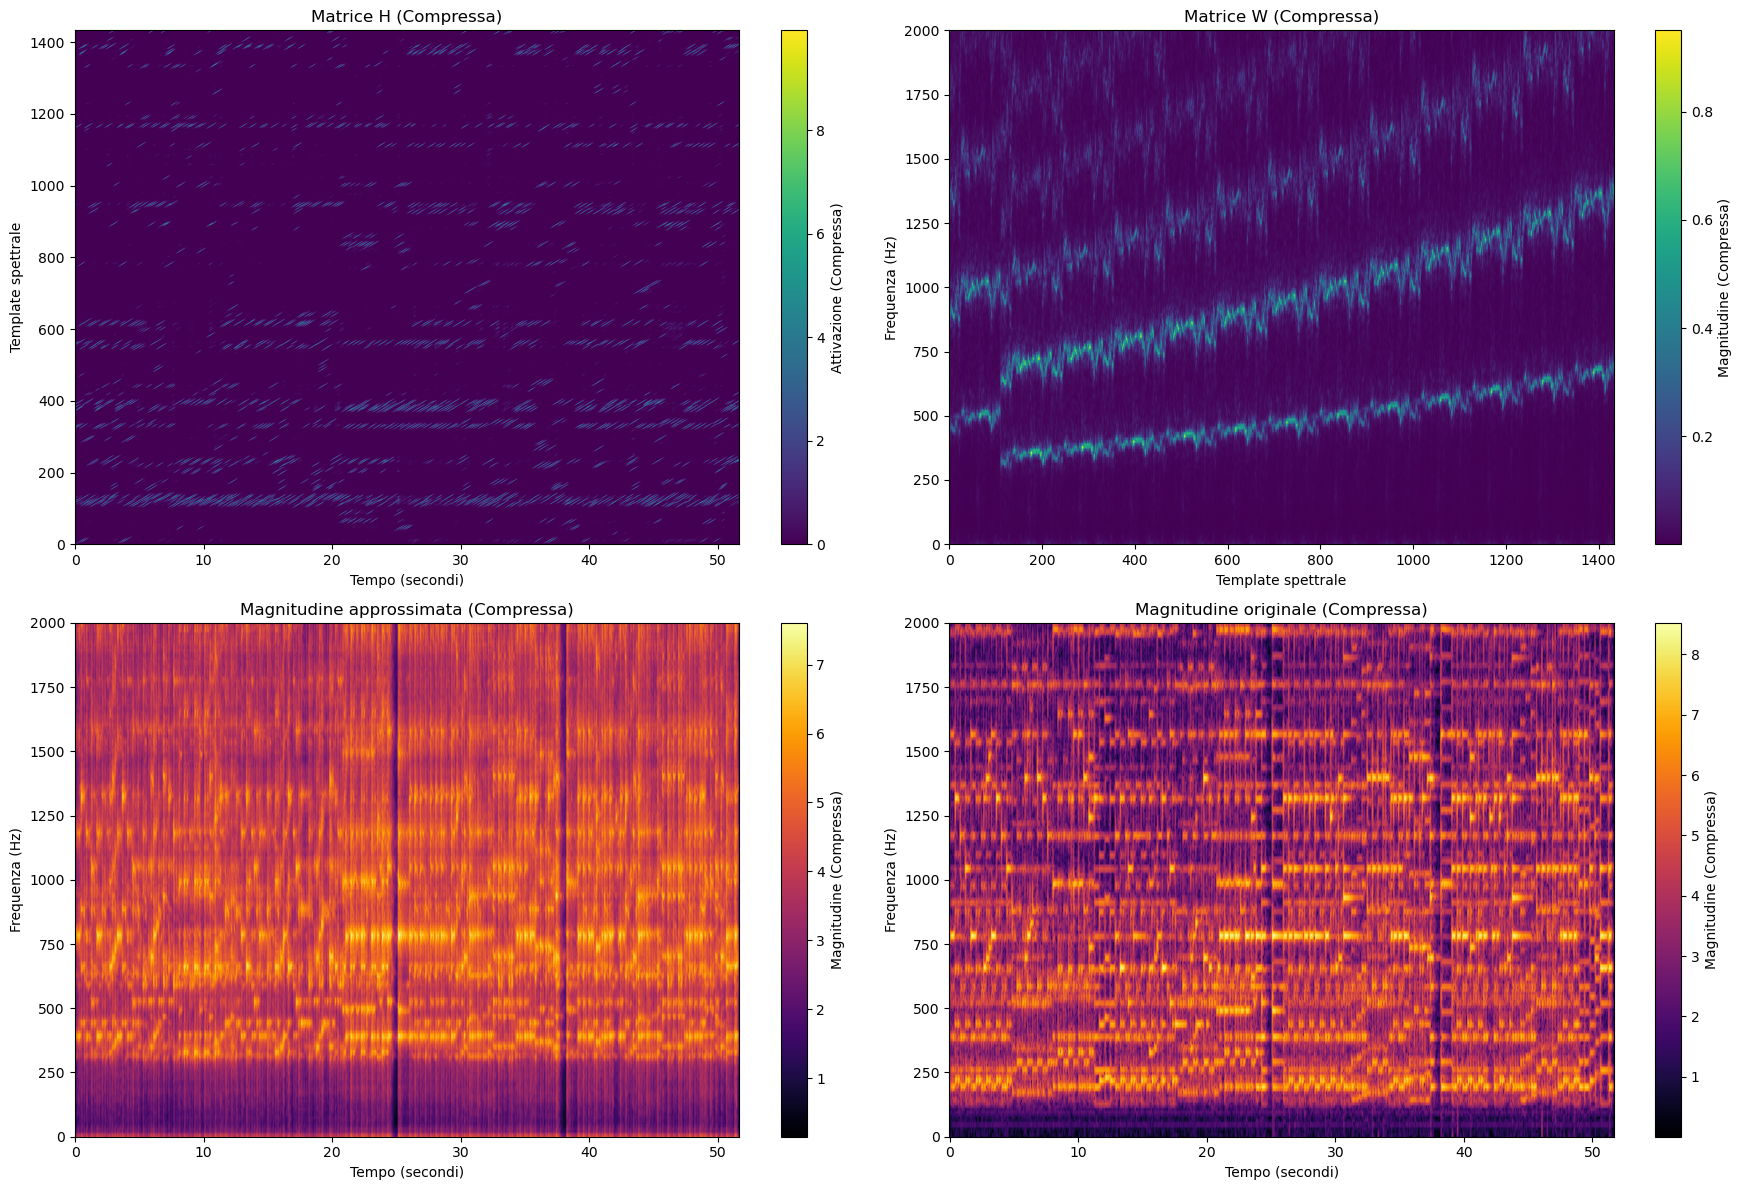

In [ ]:
# Test visualize_nmf
# Chiamata della funzione di visualizzazione
visualize_nmf_with_time_axis(Y_target, W, H, Fs, time_res, gamma=2 )

## Question 3

In [16]:
# Replace the magnitude frames by complex valued frames


# Re-synthesize using ISTFT


# Re-synthesize using Griffin-Lim algorithm



In [17]:
# Save result


In [18]:
# Phase check 
# ISTFT


# Griffin-Lim


In [19]:
# Play target


In [20]:
# Play source


In [21]:
# Play new target - ISTFT


In [22]:
# Play new target - GF


## Question 4

In [23]:
# Define the function timbre_transfer
def timbre_transfer(t, s, fs, hop_size=1024, win_length=4096, resynth='gf', plot=False):
    """Transfer the timbre from the source to the target

    Args:
        t: target waveform
        s: source waveform
        fs: sampling frequency
        hop_size: hop size used for the STFT computation and the re-synthesis
        win_length: length of the window used for the STFT computation and the re-synthesis
        resynth: method used for the audio re-synthesis. Methods available: 'gf' = Griffin-Lim, 'istft' = Inverse STFT
        plot: boolean enabling visualization of NMF matrices and target spectrogram 

    Returns:
        y: audio waveform resynthesized through the chosen method
    """
    
    return y

## Question 5

In [24]:
# Use the function timbre_tansfer for all the possible combinations of source and target

